In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 10.0)
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
from PIL import Image
from scipy.signal import convolve2d
from skimage.measure import block_reduce, find_contours
from matplotlib.patches import Rectangle
from kural_core.models import *
from kural_core.data_processing import *
from kural_core.functions import *
from kural_core.train_model import train_model
import pickle
from scipy.misc import imresize
from scipy.ndimage import morphology
from scipy.spatial import ConvexHull
from skimage import measure
from matplotlib import animation, rc
from IPython.display import HTML, display, clear_output
from os import listdir
from nd2reader import ND2Reader
from ipywidgets import widgets, Layout

PATH = r'D:\Code\kural_work\actin_gan_data\\'

In [2]:
img_file = ND2Reader(PATH+'NDSequence001.nd2')

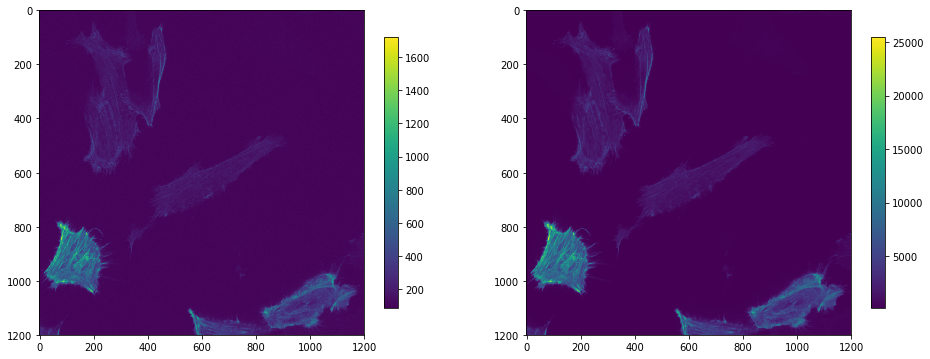

In [298]:
fig, ax = plt.subplots(1,2,figsize=(16,10))
for i in range(2):
    mappable = ax[i].imshow(img_file.get_frame_2D(c=i,v=0))
    plt.colorbar(mappable=mappable, ax=ax[i], shrink=0.5)

In [293]:
test_img = img_file.get_frame_2D(c=1,v=0)

In [294]:
test_img = torch.tensor(np.float32(test_img[8:-8,8:-8]))[None, None]

In [295]:
test_img.shape

torch.Size([1, 1, 1184, 1184])

In [296]:
test_img = (test_img-test_img.mean())/test_img.std()

In [297]:
test_out = model.features(test_img.cuda())

In [298]:
test_guess = np.zeros((34,34))
for i in range(34):
    for j in range(34):
        test_guess[i,j] = nn.Softmax(1)(model.classify(test_out[:,:,i:i+4,j:j+4].contiguous().view(1,128*4*4))).data.cpu().numpy()[0,1]

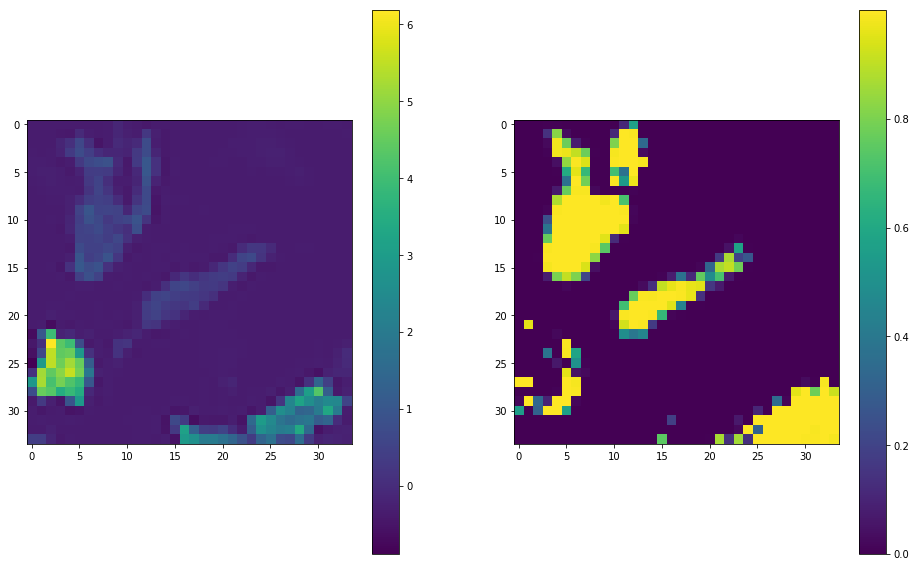

In [299]:
resized_img = np.array(Image.fromarray(test_img[0,0,:,:].data.numpy()).resize(size=(34,34),resample=Image.LANCZOS))
fig, ax = plt.subplots(1,2,figsize=(16,10))
m = ax[0].imshow(resized_img)
plt.colorbar(mappable=m, ax=ax[0])
m = ax[1].imshow(test_guess)
plt.colorbar(mappable=m, ax=ax[1])


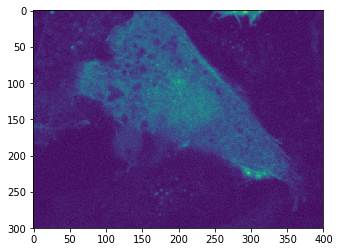

In [336]:
plt.imshow(test_img[0,0,:300,-500:-100])

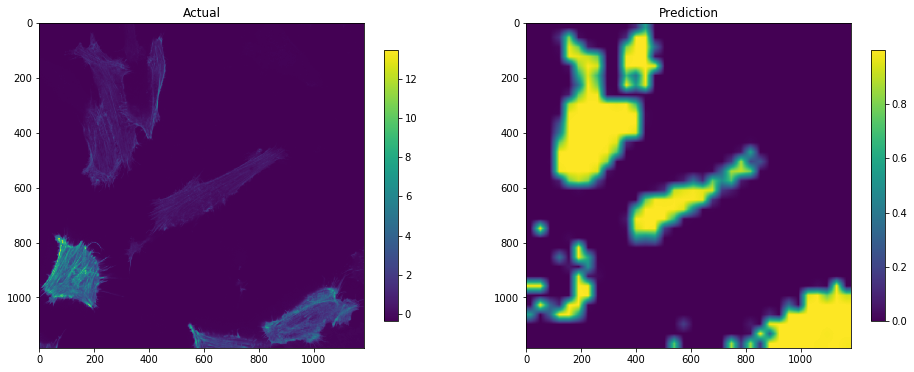

In [300]:
resized_img = np.array(Image.fromarray(test_guess).resize(size=(1184,1184),resample=Image.LINEAR))
fig, ax = plt.subplots(1,2,figsize=(16,10))
m = ax[0].imshow(test_img[0,0])
ax[0].set_title('Actual')
plt.colorbar(mappable=m, ax=ax[0],shrink=0.5)
m = ax[1].imshow(resized_img)
ax[1].set_title('Prediction')
plt.colorbar(mappable=m, ax=ax[1],shrink=0.5)
plt.show()

In [8]:
nf = 500#len(img_file.metadata['fields_of_view'])
he = np.zeros((nf, 1, img_file.metadata['height'], img_file.metadata['width']),dtype=np.float32)
le = np.zeros((nf, 1, img_file.metadata['height'], img_file.metadata['width']),dtype=np.float32)
for f in range(500,1000):
    he[f-500,0] = img_file.get_frame_2D(c=1,v=f)
    le[f-500,0] = img_file.get_frame_2D(c=0,v=f)

In [9]:
he = torch.tensor(he)

In [10]:
le = torch.tensor(le)

In [11]:
with open(PATH+'he_le_tuple_second_half.pickle','wb') as f:
    pickle.dump((he,le),f,protocol=4)

In [ ]:
with open(PATH+'he_le_tuple.pickle','rb') as f:
    he, le = pickle.load(f)

In [3]:
with open(PATH+'he_le_tuple_first_half.pickle','rb') as f:
    he, le = pickle.load(f)

In [48]:
with open(PATH+'he_le_tuple_second_half.pickle','rb') as f:
    he, le = pickle.load(f)

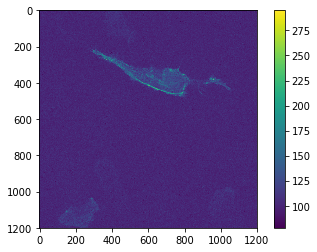

In [12]:
plt.imshow(le[0,0])
plt.colorbar()

In [175]:
ds = ActinGanDataset(he, le)

In [177]:
with open(PATH+'actin_with_classes.pickle','rb') as f:
    imgs, classification = pickle.load(f)
actin_img = []
img_class = []
for i in range(imgs[0].shape[0]):
    actin_img.append((imgs[0][i:i+1],imgs[1][i:i+1]))
    img_class.append(classification[i].item())

In [10]:
actin_img = []
img_class = []

In [206]:
def display_actin():
    clear_output(wait=True)
    _, ax = plt.subplots(1,2,figsize=(16,10))
    chance = 0
    while chance < 0.8:
        idx = np.random.choice(len(ds))
        h,l = ds[idx]
        y_pred = nn.Softmax(1)(model(h.cuda())).cpu().data.numpy()
        chance = np.sum(y_pred[0][3])
    m = ax[0].imshow(h[0,0])
    plt.colorbar(mappable=m, ax=ax[0],shrink=0.5)
    m = ax[1].imshow(l[0,0])
    plt.colorbar(mappable=m, ax=ax[1],shrink=0.5)
    plt.show()
    def cls0(btn):
        actin_img.append((h.clone().detach().data,l.clone().detach().data))
        img_class.append(0)
        display_actin()
    def cls1(btn):
        actin_img.append((h.clone().detach().data,l.clone().detach().data))
        img_class.append(1)
        display_actin()
    def cls2(btn):
        actin_img.append((h.clone().detach().data,l.clone().detach().data))
        img_class.append(2)
        display_actin()
    def cls3(btn):
        actin_img.append((h.clone().detach().data,l.clone().detach().data))
        img_class.append(3)
        display_actin()
    def cls4(btn):
        actin_img.append((h.clone().detach().data,l.clone().detach().data))
        img_class.append(4)
        display_actin()
    def cls5(btn):
        actin_img.append((h.clone().detach().data,l.clone().detach().data))
        img_class.append(5)
        display_actin()
    def cls6(btn):
        actin_img.append((h.clone().detach().data,l.clone().detach().data))
        img_class.append(6)
        display_actin()
    b0 = widgets.Button(description='Noise')
    b0.on_click(cls0)
    b1 = widgets.Button(description='Blobby, dead')
    b1.on_click(cls1)
    b2 = widgets.Button(description='Punta')
    b2.on_click(cls2)
    b3 = widgets.Button(description='Filamentous')
    b3.on_click(cls3)
    b4 = widgets.Button(description='Bright but bad')
    b4.on_click(cls4)
    b5 = widgets.Button(description='Wavy Signal')
    b5.on_click(cls5)
    b6 = widgets.Button(description='Spinning Disk Error')
    b6.on_click(cls6)
    w = widgets.HBox([b0, b1, b2, b3, b4, b5, b6])
    display(w)

In [157]:
def fix_unknown(i):
    clear_output(wait=True)
    while img_class[i] is not 4:
        i += 1
        if i>410: return
    _, ax = plt.subplots(1,2,figsize=(16,10))
    h,l = actin_img[i]
    m = ax[0].imshow(h[0,0])
    plt.colorbar(mappable=m, ax=ax[0],shrink=0.5)
    m = ax[1].imshow(l[0,0])
    plt.colorbar(mappable=m, ax=ax[1],shrink=0.5)
    plt.show()
    def return_i():
        return i
    def cls0(btn):
        img_class[return_i()] = 4
        fix_unknown(return_i()+1)
    def cls1(btn):
        img_class[return_i()] = 5
        fix_unknown(return_i()+1)
    def cls2(btn):
        img_class[return_i()] = 6
        fix_unknown(return_i()+1)
    b0 = widgets.Button(description='Bright but bad')
    b0.on_click(cls0)
    b1 = widgets.Button(description='Wavy Signal')
    b1.on_click(cls1)
    b2 = widgets.Button(description='Spinning Disk Error')
    b2.on_click(cls2)
    w = widgets.HBox([b0, b1, b2])
    display(w)

In [158]:
fix_unknown(0)

IndexError: list index out of range

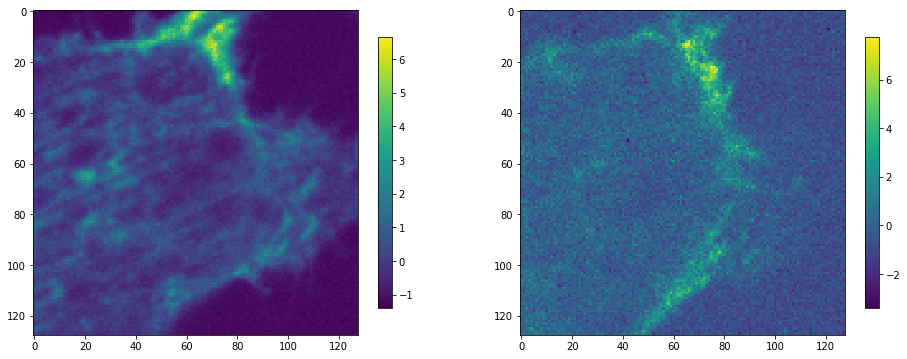

In [207]:
display_actin()

In [194]:
img_class.pop()
actin_img.pop();

In [201]:
img_class[-1]=2

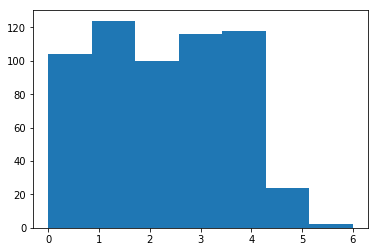

In [208]:
plt.hist(img_class, bins=7)
plt.show()

In [209]:
imgs = (torch.cat([a for a, _ in actin_img]), torch.cat([b for _, b in actin_img]))
classification = torch.tensor(img_class)

In [210]:
with open(PATH+'actin_with_classes.pickle','wb') as f:
    pickle.dump((imgs,classification),f,protocol=4)

In [4]:
with open(PATH+'actin_with_classes.pickle','rb') as f:
    imgs, classification = pickle.load(f)

In [44]:
with open(PATH+'actin_and_not_actin.pickle','wb') as f:
    pickle.dump((actin,not_actin),f,protocol=4)

In [3]:
with open(PATH+'actin_and_not_actin.pickle','rb') as f:
    actin, not_actin = pickle.load(f)

In [45]:
idx_order = np.random.permutation(actin[0].shape[0]+not_actin[0].shape[0])

In [46]:
na = actin[0].shape[0]
nna = not_actin[0].shape[0]
actin_class = list(range(0,na))
not_actin_class = list(range(na,na+nna))
all_actin = torch.cat([actin[0],not_actin[0]])
classification = []
imgs = []
for i in idx_order:
    imgs.append(all_actin[i])
    classification.append(torch.tensor(1) if i in actin_class else torch.tensor(0))

In [48]:
classification = torch.stack(classification)

In [5]:
he_imgs = imgs[0]

In [60]:
classification.shape

torch.Size([224])

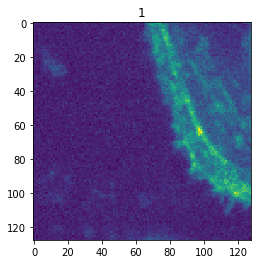

In [58]:
found = False
while not found:
    idx = np.random.choice(imgs.shape[0])
    if classification[idx] == 1: found=True
plt.imshow(imgs[idx,0])
plt.title(f'{classification[idx]}')
plt.show()

In [249]:
with open(PATH+'imgs_and_classification.pickle','wb') as f:
    pickle.dump((imgs,classification),f,protocol=4)

In [2]:
with open(PATH+'imgs_and_classification.pickle','rb') as f:
    imgs, classification = pickle.load(f)

In [339]:
mini = imgs.min()
maxi = imgs.max()
imgs = (imgs-mini)/(maxi-mini)


In [340]:
with open(PATH+'actin_classifier_model_image_normalization.pickle','wb') as f:
    pickle.dump((mini, maxi),f)

In [3]:
classification = classification.long()

In [212]:
ds = ActinClassifierDataset(he_imgs,classification)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, rand_seed=42, nORp=1)
bs = 50
clip = 50
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(val_idx))
model = ActinClassifierModel(7).cuda()
opt = torch.optim.Adam(model.parameters())
train_loss = []
val_loss = []
accuracy = []
criterion = nn.CrossEntropyLoss()

In [213]:
model, _tl, _vl, _acc = train_model(model, train_dl, val_dl, opt, criterion, lr_start=1e-4, lr_end=1, epochs=1000, cycles=1, is_classification=True, lr_cycle='sin')
train_loss += _tl
val_loss += _vl
accuracy += _acc
torch.save(model.state_dict(),r'D:\Code\kural_work\actin_classifier_model.pth')
# model, _tl, _vl, _acc = train_model(model, train_dl, val_dl, opt, criterion, lr_start=1e-3, lr_end=None, epochs=10, cycles=1, is_classification=True, lr_cycle='cos')
# train_loss += _tl
# val_loss += _vl
# accuracy += _acc
# torch.save(model.state_dict(),r'D:\Code\kural_work\actin_classifier_model.pth')

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Spent 22m 43s doing 1000 total steps for an average of 1.4s per step.
><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><


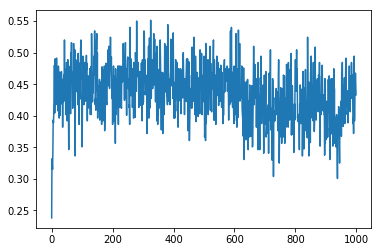

In [171]:
plt.plot(accuracy[0:])

In [37]:
lr_range = [1e-6*(10**(i/5)) for i in range(30)]
for lr in lr_range:
    model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start=lr, lr_end=None, epochs=1, cycles=1)
    train_loss += _tl
    val_loss += _vl
    if _tl[0]>100: break

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Spent 0m  2s doing 1 total steps for an average of 1.9s per step.
><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><


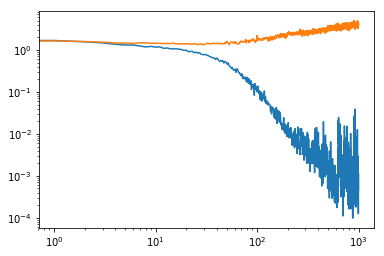

In [172]:
x = list(range(len(train_loss)))
# x = lr_range
slc = slice(0,len(train_loss))
plt.plot(x[slc],train_loss[slc])
plt.plot(x[slc],val_loss[slc])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [10]:
class_labels = ['Noise', 'Blob', 'Punctae', 'Filaments', 'Bright but bad', 'Wavy Signal', 'Spinning disk error']

In [13]:
model = ActinClassifierModel(7).cuda()
model.load_state_dict(torch.load(r'D:\Code\kural_work\actin_classifier_model.pth'))
for p in model.parameters():
    p.requires_grad = False
ds = ActinClassifierDataset(he_imgs,classification)

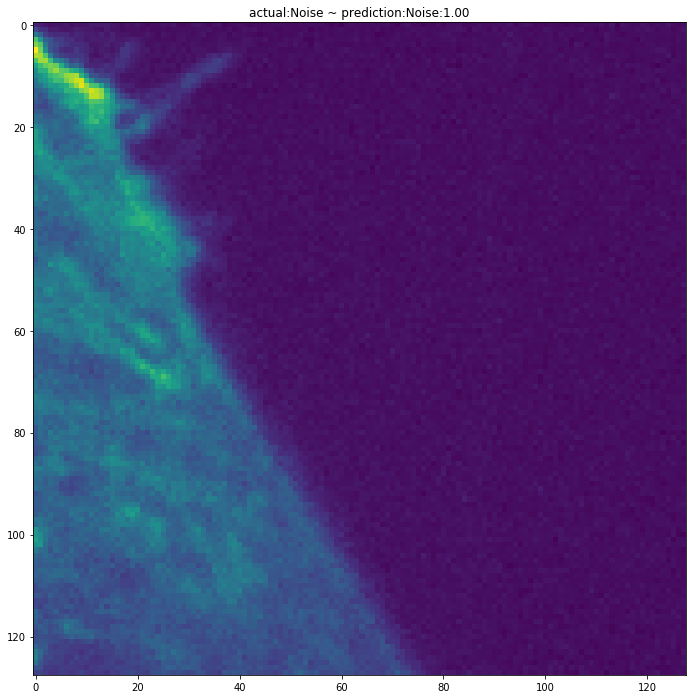

In [77]:
model.eval()
idx = np.random.choice(len(ds))
# _, ax = plt.subplots(1,2,figsize=[16,10])
i, c = ds[idx]
plt.figure(figsize=(12,12))
plt.imshow(i[0])
y_pred = nn.Softmax(1)(model(i[None].cuda())).cpu().data.numpy()
plt.title(f'actual:{class_labels[c]} ~ prediction:{class_labels[np.argmax(y_pred[0])]}:{y_pred[0][c]:.2f}')
plt.show()

In [73]:
y_pred

array([[0.82206035, 0.17793962]], dtype=float32)

In [309]:
good_actin = []
not_good_actin = []

In [79]:
ds = ActinGanDataset(he, le)
model.eval()
def display_guesses():
    clear_output(wait=True)
    fig, ax = plt.subplots(2,3,figsize=(18,10))
    ax = ax.flatten()
    chance_list = []
    h_list = []
    for i in range(6):
        chance = 0
        while chance < 0.5:
            idx = np.random.choice(len(ds))
            h,_ = ds[idx]
            chance = nn.Softmax(1)(model(h.cuda())).data.cpu().numpy()[0,1]
        h_list.append(h)
        chance_list.append(chance)
        m = ax[i].imshow(h[0,0])
    fig.subplots_adjust(wspace=0.01)
    plt.show()
    flag = [False]*6
    def btn0(btn):
        flag[0]=not flag[0]
    def btn1(btn):
        flag[1]=not flag[1]
    def btn2(btn):
        flag[2]=not flag[2]
    def btn3(btn):
        flag[3]=not flag[3]
    def btn4(btn):
        flag[4]=not flag[4]
    def btn5(btn):
        flag[5]=not flag[5]
    def all_btn(btn):
        for i in range(6):
            if flag[i]: 
                not_good_actin.append(h_list[i].data.detach().clone())
            else:
                good_actin.append(h_list[i].data.detach().clone())
                
        display_guesses()
    b0 = widgets.Button(description='Flip 1')
    b0.on_click(btn0)
    b1 = widgets.Button(description='Flip 2')
    b1.on_click(btn1)
    b2 = widgets.Button(description='Flip 3')
    b2.on_click(btn2)
    b3 = widgets.Button(description='Flip 4')
    b3.on_click(btn3)
    b4 = widgets.Button(description='Flip 5')
    b4.on_click(btn4)
    b5 = widgets.Button(description='Flip 6')
    b5.on_click(btn5)
    b_all = widgets.Button(description='Save All')
    b_all.on_click(all_btn)
    w = widgets.HBox([b0, b1, b2, b3, b4, b5, b_all])
    display(w)

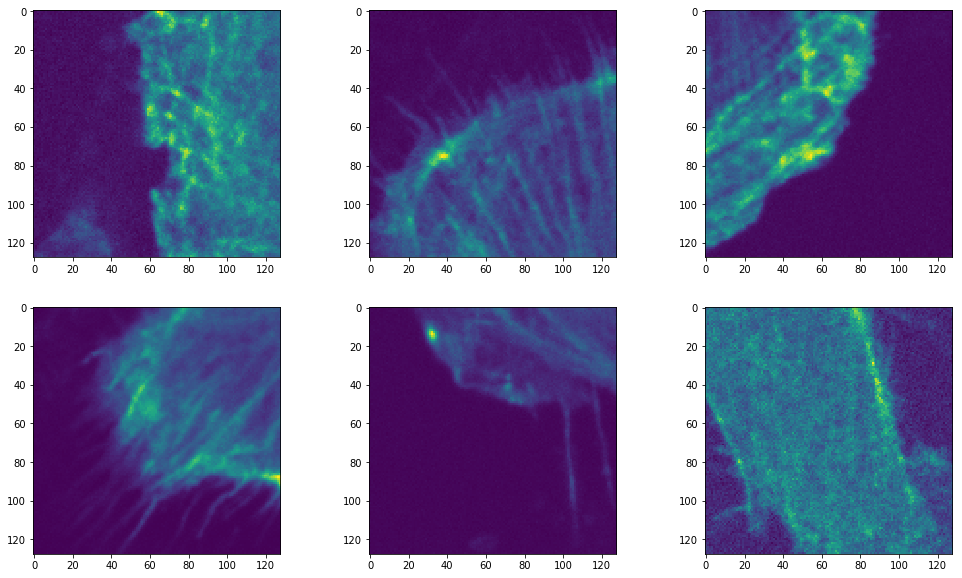

In [86]:
display_guesses()

ValueError: 'a' must be greater than 0 unless no samples are taken

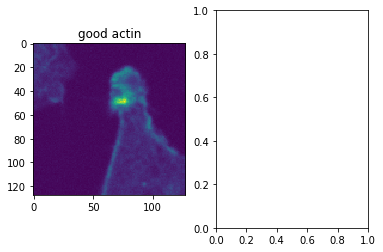

In [307]:
_, ax = plt.subplots(1,2)
idx = np.random.choice(len(good_actin))
ax[0].imshow(good_actin[idx][0,0])
ax[0].set_title('good actin')
idx = np.random.choice(len(not_good_actin))
ax[1].imshow(not_good_actin[idx][0,0])
ax[1].set_title('not good actin')
plt.show()

In [231]:
print(len(good_actin), len(not_good_actin))

568 236


In [232]:
with open('tmp.pickle','wb') as f:
    pickle.dump((good_actin, not_good_actin), f, protocol=4)

In [236]:
tmp = torch.cat(good_actin+not_good_actin)

In [238]:
cls = torch.stack([torch.tensor(1)]*len(good_actin) + [torch.tensor(0)]*len(not_good_actin))

In [241]:
perm = np.random.permutation(tmp.shape[0])

In [ ]:
imgs = torch.cat([imgs, tmp[perm]])

In [243]:
classification = torch.cat([classification, cls[perm]])

In [246]:
imgs.shape

torch.Size([1651, 1, 128, 128])

In [248]:
torch.sum(classification==0)

tensor(920)

In [245]:
classification.shape

torch.Size([1651])

In [265]:
a_chance = []
img_list = []
a_true = []
model.eval()
for idx in range(len(ds)):
    i, c = ds[idx]
    y_pred = nn.Softmax(1)(model(i[None].cuda())).cpu().data.numpy()[0,1]
    img_list.append(i)
    a_chance.append(y_pred)
    a_true.append(c)

In [269]:
a_true = torch.stack(a_true)

tensor([0, 1, 0,  ..., 0, 0, 0])

In [270]:
a_true = a_true.data.numpy();a_true

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [271]:
a_chance = np.array(a_chance);a_chance

array([0.14915784, 0.9344963 , 0.1484649 , ..., 0.15068129, 0.14871387,
       0.14794993], dtype=float32)

In [273]:
img_list = torch.cat(img_list).data.numpy()

In [293]:
certain_true, certain_false, uncertain, wrong_true, wrong_false = ([] for _ in range(5))
for i in range(len(a_chance)):
    if a_true[i] == 1:
        if a_chance[i]>0.9:
            certain_true.append((a_chance[i],img_list[i]))
        if a_chance[i]<0.1:
            wrong_true.append((a_chance[i],img_list[i]))
        if a_chance[i]>0.45 and a_chance[i]<0.55:
            uncertain.append((a_chance[i],a_true[i],img_list[i]))
    if a_true[i] == 0:
        if a_chance[i]>0.5:
            wrong_false.append((a_chance[i],img_list[i]))
        if a_chance[i]<0.1:
            certain_false.append((a_chance[i],img_list[i]))
        if a_chance[i]>0.45 and a_chance[i]<0.55:
            uncertain.append((a_chance[i],a_true[i],img_list[i]))
print(len(certain_false), len(certain_true), len(uncertain), len(wrong_false), len(wrong_true))

0 103 26 45 0


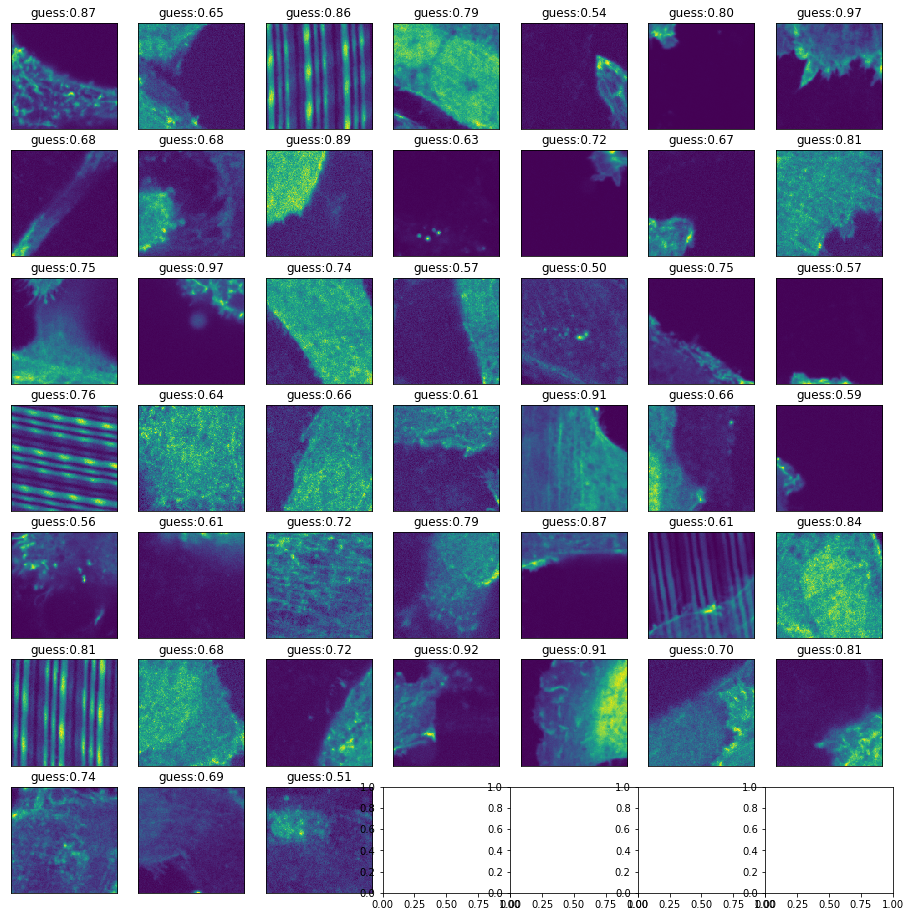

In [296]:
which_list = wrong_false
fig, ax = plt.subplots(7,7,figsize=(16,16))
ax = ax.flatten()
for j in range(len(which_list)):
    ax[j].imshow(which_list[j][1])
    ax[j].set_yticks([])
    ax[j].set_xticks([])
#     ax[j].set_title(f'actual:{which_list[j][1]} ~ guess:{which_list[j][0]:.2f}')
    ax[j].set_title(f'guess:{which_list[j][0]:.2f}')
fig.subplots_adjust(wspace=0,hspace=0.2)

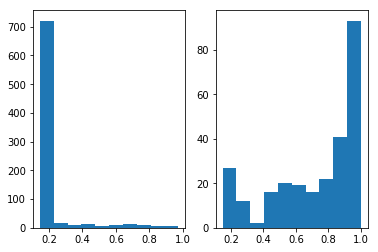

In [291]:
fig, ax = plt.subplots(1,2)
for i in range(2):
    ax[i].hist(a_chance[a_true==i])
plt.show()

In [111]:
count = 0
for i in range(len(classification)):
    if classification[i]==1:
        count+=1
print(count/len(classification))

0.24860853432282004


In [234]:
params = model.parameters()
mods = model.modules()

In [235]:
p = 0
m = 0
for _ in model.parameters():
    p+=1
for _ in model.modules():
    m+=1

In [236]:
p,m

(44, 41)

In [223]:
p = next(params)
m = next(mods)

In [230]:
m = next(mods)

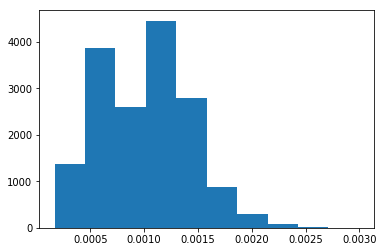

In [285]:
idx = np.random.choice(len(ds))
i, c = ds[idx]
plt.hist(i.flatten())
plt.show()

In [206]:
import time

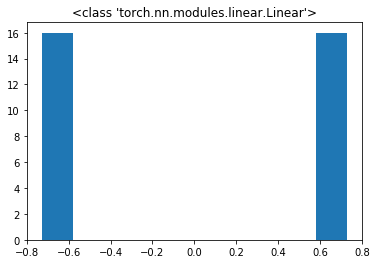

Press Enter to continue.


In [57]:
for m in model.modules():
    if not (isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.Linear)): continue
    clear_output(True)
#     print(p)
    plt.hist(m.weight.grad.data.cpu().numpy().flatten())
    plt.title(type(m))
    plt.show()
    _ = input('Press Enter to continue.')

In [399]:
i = 0;
for m in model.modules():
    if isinstance(m, nn.Sequential):
        print(i)
        i+=1

0
1
2
3
4
5


In [401]:
m = list(model.modules())

In [443]:
m[9]

Sequential(
  (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
)

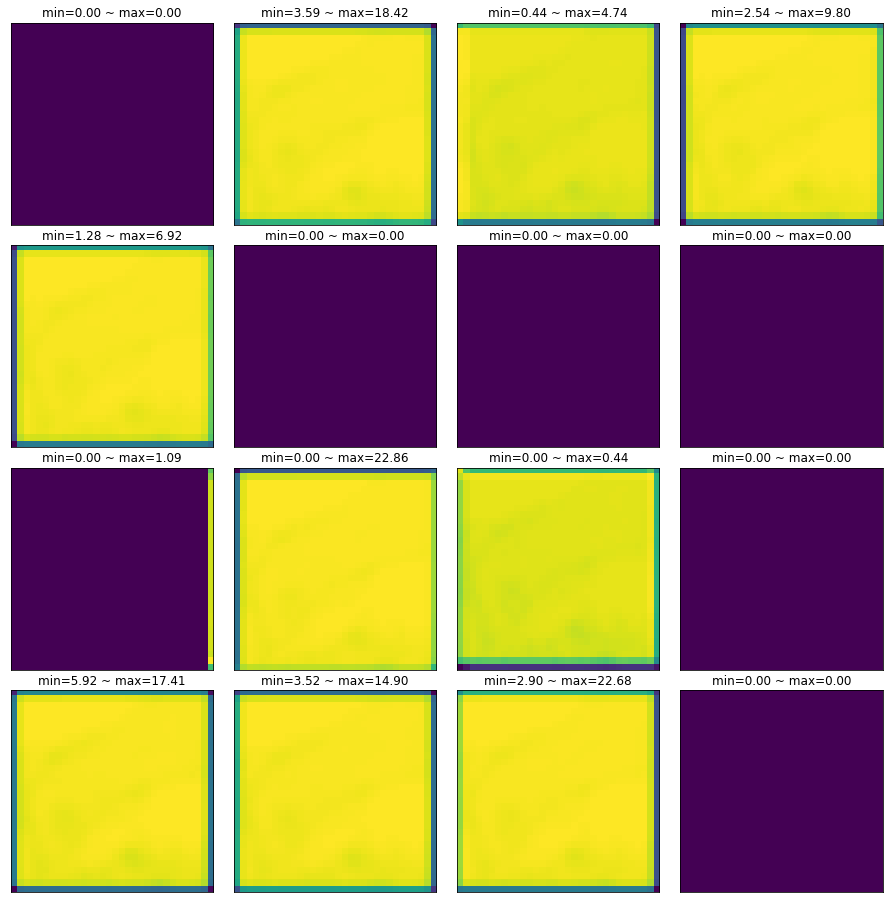

In [441]:
out = i[None].cuda()
for j in range(3,10):
    out = m[j](out)
fig, ax = plt.subplots(4,4,figsize=(16,16))
ax = ax.flatten()
for j in range(len(ax)):
    o = out[0,j].data.cpu()
    ax[j].imshow(o)
    ax[j].set_yticks([])
    ax[j].set_xticks([])
    ax[j].set_title(f'min={o.min():.2f} ~ max={o.max():.2f}')
fig.subplots_adjust(wspace=0,hspace=0.1)